### **Part 1: Data Processing**

This notebook presents the steps to deal with the original dataset.
We will go through the original dataset as well as integrating into the trainable forms such as pytorch dataset storage. This noteboook has several sections:


1.   Data overview
2.   Data processing steps
3.   Data integration and flexible storage


The subsequent processing and the model training processes can be found in another notebook along with the team's submission.

Note: due to the limited storage of NYU Classes, to achieve high-efficiency submission, we are not going to submit the datasets (raw and processes) online.

To get access to the original dataset, please visit https://www.kaggle.com/xainano/handwrittenmathsymbols.

## Data overview

We start overviewing the data. We first load the required packages:


1.   `os`: a standard module for operating system-related operations.
2.   `random`: introduces randomness.
3.   `collections`: allows statistical view of the data.
4.   `matplotlib.pyplot`: a standard module for data visualization.

Variable declaration:


*   opd: the parent directory of the dataset
*   all_cats: list of all the categories
*   all_dicts: count the appearance of each category

Function declaration:

*   `idx_label`: transform between index (integer, 0~81) and category name (string).
*   `load_data(opd)`: process the original data into the following format: (picture_directory, label).



In [ ]:
# Data Overview
import os
import random
import collections
import matplotlib.pyplot as plt



opd = 'extracted_images'
all_cats = [label for label in os.listdir(opd)]
all_dicts = {i:0 for i in all_cats}
print('Total number of categories: ', len(all_cats))

# Utility function
def idx_label(target):
    if target in all_cats:
        return all_cats.index(target)
    else:
        return all_cats[target]

def load_data(opd):
    selection = list()
    for label in os.listdir(opd):
        selection += [(pic_dir, idx_label(label)) for pic_dir in os.listdir(os.path.join(opd, label))]
    return selection


for label in os.listdir(opd):
    a, b, selection = [], [], []
    for pic_dir in os.listdir(os.path.join(opd, label)):
        all_dicts[label] += 1

Total number of categories:  82


We plot the bar chart to see the distribution of the categories.

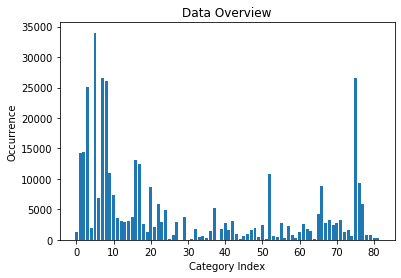

In [ ]:
plt.bar(range(82), [all_dicts.get(xtick, 0) for xtick in all_cats], align='center',yerr=0.000001)
plt.xlabel('Category Index')
plt.ylabel('Occurrence')
plt.title("Data Overview")
plt.show()

## Splitting Data

We mainly use the module `splitfolders` to split the data. We choose the splitting ratio to be 60%, 20%, 20%.

In [ ]:
# Now we want to split into train, test and cross validation set.
import os
import numpy as np
import torch
import torchvision
from PIL import Image

!pip install split_folders
import splitfolders

# Splitting Folder

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

OUTPUT_PATH = "images_split"    
    

SEED = 45
seed_everything(SEED)
splitfolders.ratio('extracted_images', output=OUTPUT_PATH, seed=SEED, ratio=(.6, .2, .2))

Copying files: 6 files [00:00, 58.04 files/s]

Copying files: 375974 files [43:26, 144.27 files/s]


## Dataset Class Inheritance

We create the `SymbolData` class to store the data. To store the data into tensor form, we define a method of `load_picture` to process the data into tensors after normalization steps.

Also, to beautify the form of data, we call `SymbolData.process()` to store all the data into the required form: a tuple containing tensor and its corresponding category.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SymbolData(Dataset):
    def __init__(self, inputs, dataset_type, opd, transform=None):
        self.all_data = inputs
        self.dataset_type = dataset_type
        self.opd = opd
        self.all_tensors = []
        self.labels = [i[1] for i in self.all_data]

    def load_picture(self, file_name):
        loader = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])
        image = Image.open(file_name)
        image = loader(image).unsqueeze(0)
        return image.to(torch.float)
    
    def process(self):
        self.all_tensors = [self.load_picture(os.path.join(self.opd, idx_label(i[1]), i[0])) for i in self.all_data]

    def __getitem__(self, index):
        pic_tensor = self.all_tensors[index]
        label = self.all_data[index][1]
        return pic_tensor, label
    
    def __len__(self):
        return len(self.all_data)

## Process the Data
We treat the training, testing and validation dataset respectively into the required form of SymbolData object.

In [ ]:
par = OUTPUT_PATH


train_path = os.path.join(par, 'train')
test_path = os.path.join(par,'test')
cv_path = os.path.join(par, 'val')

print(len(load_data(train_path)), len(load_data(test_path)), len(load_data(cv_path)))


tp = os.path.join(par, 'train')
ttp = os.path.join(par, 'test')
vp = os.path.join(par, 'val')

train_data = SymbolData(load_data(train_path), 'train', train_path)
test_data = SymbolData(load_data(test_path), 'test', test_path)
val_data = SymbolData(load_data(cv_path), 'val', cv_path)

train_data.process()
test_data.process()
val_data.process()

print('Data Processing Completed.')

225552 75261 75161
Data Processing Completed.


## Storing Data

After processing the data into required form, we save the model locally into a single dataset using pickle. For further usage, we will upload the .pkl file to Google Drive and implement the whole project structure based on that dataset.

In [ ]:
import pickle
SAVE_PATH = 'processed'


file_object = open(os.path.join(SAVE_PATH, 'final_data'), 'wb')
pickle.dump(all_cats, file_object)
pickle.dump(train_data, file_object)
pickle.dump(test_data, file_object)
pickle.dump(val_data, file_object)
file_object.close()
print('Data Storage Completed.')

Data Storage Completed.


## Conclusion
In this part, we have successfully stored the data into neat forms and make it usable for future works.

For the details of how the team utilizes data and perform the CNN algorithm for the task, please see another notebook, `ml_project.ipynb`. Also, more details about the data processing part can be found in the final report.